Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AICC=227.935, Time=1.22 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AICC=233.386, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AICC=169.156, Time=2.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AICC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AICC=260.389, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AICC=180.507, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AICC=171.268, Time=0.85 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AICC=170.853, Time=0.71 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AICC=167.499, Time=0.38 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AICC=169.821, Time=0.67 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AICC=172.228, Time=1.14 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AICC=221.790, Time=0.27 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AICC=169.708, Time=0.41 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AICC=169.905, Time=0.37 sec
 ARIMA(2,0,1)(0,1,1)[1

 This problem is unconstrained.



At iterate   15    f=  9.20783D-01    |proj g|=  3.22728D+00

At iterate   16    f=  9.18870D-01    |proj g|=  6.79775D-01

At iterate   17    f=  9.18765D-01    |proj g|=  1.16345D-01

At iterate   18    f=  9.18759D-01    |proj g|=  1.62530D-01

At iterate   19    f=  9.18731D-01    |proj g|=  3.06124D-01

At iterate   20    f=  9.18666D-01    |proj g|=  5.06292D-01

At iterate   21    f=  9.18491D-01    |proj g|=  8.36397D-01

At iterate   22    f=  9.18058D-01    |proj g|=  1.30391D+00

At iterate   23    f=  9.17053D-01    |proj g|=  1.89303D+00

At iterate   24    f=  9.15027D-01    |proj g|=  2.41659D+00

At iterate   25    f=  9.11951D-01    |proj g|=  2.37510D+00

At iterate   26    f=  9.11904D-01    |proj g|=  2.17662D+00

At iterate   27    f=  9.09176D-01    |proj g|=  1.37530D+00

At iterate   28    f=  9.08383D-01    |proj g|=  1.73000D+00

At iterate   29    f=  9.07994D-01    |proj g|=  2.06068D-01

At iterate   30    f=  9.07821D-01    |proj g|=  2.52131D-02

At iter

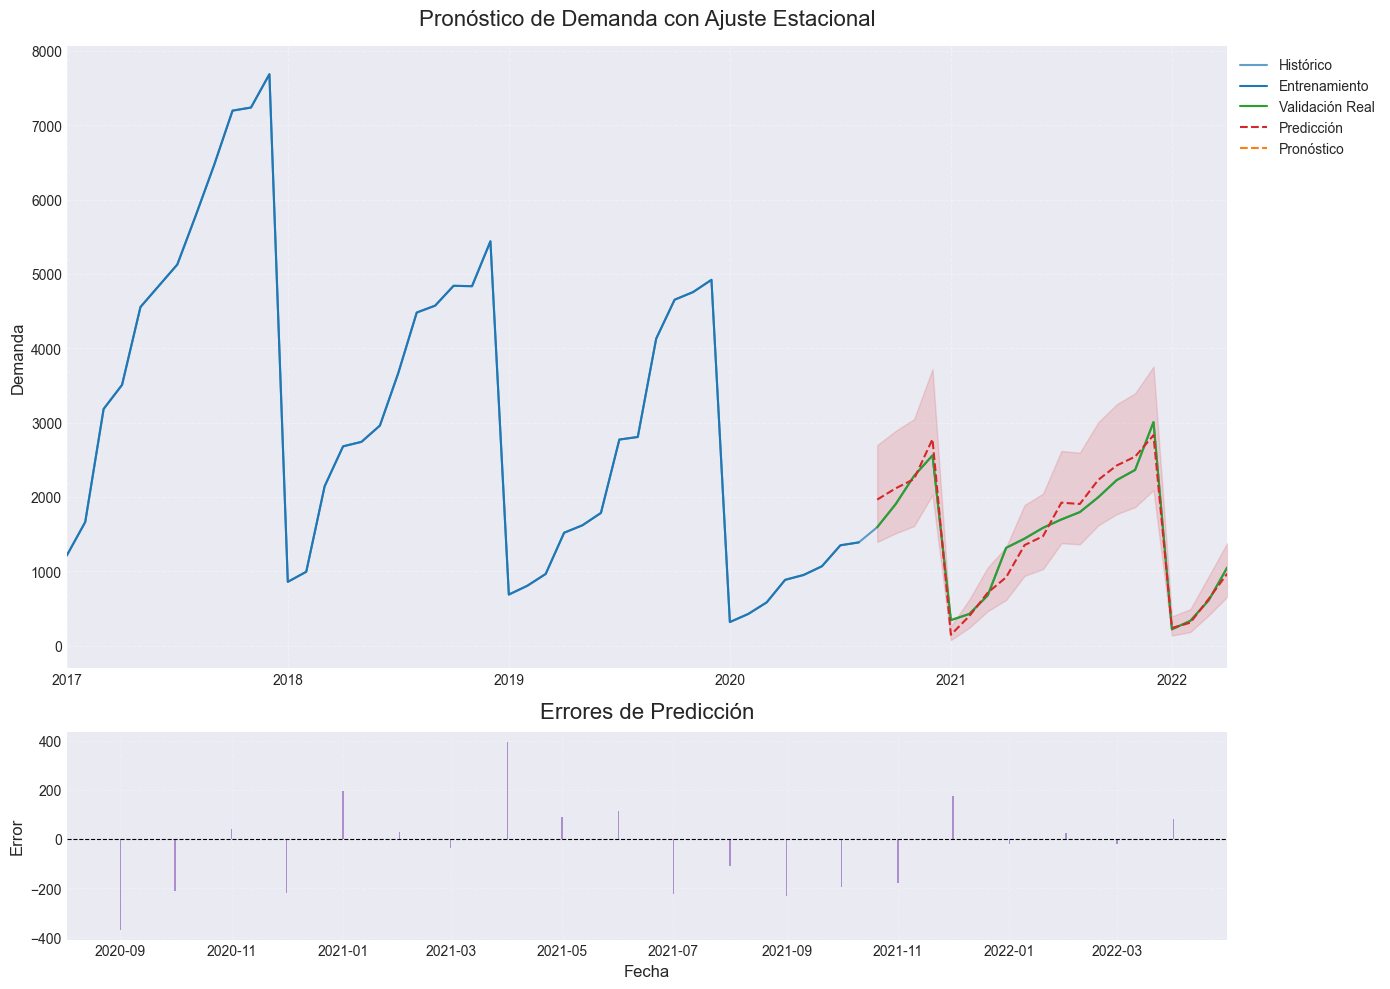


=== RESULTADOS FINALES ===
NMSPH: 11.95%
NMIS: 148.58
RMSE: 184.32
RMSE Walk-Forward: 260.63

Pronóstico para los próximos 12 meses:
  Fecha  Pronóstico  Límite Inferior  Límite Superior
2022-05     1220.11           845.04          1709.11
2022-06     1395.41           895.57          2081.86
2022-07     1810.36          1150.79          2722.11


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from scipy import stats
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (14, 8),  
    'figure.dpi': 100,          
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'grid.alpha': 0.3,
    'savefig.dpi': 150,         
    'savefig.bbox': 'tight'
})

def robust_demand_forecast(filepath):
    try:
        
        df = pd.read_csv(filepath, parse_dates=['year_month'])
        df = df.set_index('year_month').asfreq('MS')
        ts = df['Demand'].astype(float)
        
       
        def adjust_outliers(series):
            rolling_median = series.rolling(window=12, min_periods=1).median()
            rolling_iqr = series.rolling(window=12, min_periods=1).apply(
                lambda x: np.percentile(x, 75) - np.percentile(x, 25))
            bounds = (rolling_median - 3*rolling_iqr, rolling_median + 3*rolling_iqr)
            return series.clip(lower=bounds[0], upper=bounds[1])
        
        ts_clean = adjust_outliers(ts)
        
        
        ts_transformed, lambda_ = stats.boxcox(ts_clean + 1)
        ts_transformed = pd.Series(ts_transformed, index=ts.index)
        
        
        model = auto_arima(
            ts_transformed,
            seasonal=True,
            m=12,
            start_p=0,
            start_q=0,
            max_p=3,
            max_q=3,
            d=None,
            start_P=1,
            start_Q=1,
            max_P=2,
            max_Q=2,
            D=1,
            seasonal_order=(1,1,1,12),
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True,
            n_fits=50,
            information_criterion='aicc',
            with_intercept=True,
            test='kpss',
            seasonal_test='ch',
            out_of_sample_size=12,
            scoring='mse'
        )
        
        print(f"\nModelo seleccionado: SARIMA{model.order}{model.seasonal_order}")
        
        
        final_model = SARIMAX(
            ts_transformed,
            order=model.order,
            seasonal_order=model.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=True,
            trend='ct'
        ).fit(disp=True, maxiter=200)
        
        
        print("\n=== Diagnóstico Avanzado ===")
        fig_resid, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        
        resid = final_model.resid
        pd.plotting.autocorrelation_plot(resid, ax=ax1)
        pd.plotting.lag_plot(resid, lag=1, ax=ax2)
        ax3.hist(resid, bins=20, color='#1f77b4', alpha=0.7)
        stats.probplot(resid, plot=ax4)
        
        ax1.set_title('Autocorrelación')
        ax2.set_title('Lag Plot')
        ax3.set_title('Distribución de Residuos')
        ax4.set_title('QQ Plot')
        
        plt.suptitle('Diagnóstico de Residuos', y=1.02)
        plt.tight_layout()
        plt.savefig('residual_diagnostics.png', dpi=150)
        plt.close(fig_resid)
        
        
        print("\n=== Validación Walk-Forward ===")
        train_size = int(len(ts) * 0.7)
        test_size = len(ts) - train_size
        steps = 6
        
        wf_errors = []
        for i in range(train_size, len(ts) - steps + 1, steps):
            train = ts_transformed[:i]
            test = ts_transformed[i:i + steps]
            
            wf_model = SARIMAX(
                train,
                order=model.order,
                seasonal_order=model.seasonal_order
            ).fit(disp=False)
            
            forecast = wf_model.get_forecast(steps=steps)
            pred = inv_boxcox(forecast.predicted_mean, lambda_) - 1
            actual = inv_boxcox(test, lambda_) - 1
            
            rmse = np.sqrt(mean_squared_error(actual, pred))
            mape = mean_absolute_percentage_error(actual, pred) * 100
            wf_errors.append({'RMSE': rmse, 'MAPE': mape})
            print(f"Ventana {i}-{i+steps}: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
        
        wf_results = pd.DataFrame(wf_errors)
        print(f"\nMétricas Promedio Walk-Forward:\n{wf_results.mean()}")
        
        
        train, test = ts_transformed[:train_size], ts_transformed[train_size:]
        
        pred = final_model.get_prediction(
            start=train_size,
            end=len(ts_transformed)-1,
            dynamic=False
        )
        pred_mean = inv_boxcox(pred.predicted_mean, lambda_) - 1
        pred_ci = pred.conf_int()
        pred_ci_lower = inv_boxcox(pred_ci.iloc[:, 0], lambda_) - 1
        pred_ci_upper = inv_boxcox(pred_ci.iloc[:, 1], lambda_) - 1
        
        test_original = inv_boxcox(test, lambda_) - 1
        train_original = inv_boxcox(train, lambda_) - 1
        
       
        forecast_steps = 3
        forecast = final_model.get_forecast(steps=forecast_steps)
        forecast_mean = inv_boxcox(forecast.predicted_mean, lambda_) - 1
        
        
        forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), 
                                     periods=forecast_steps, freq='MS')
        jan_idx = [i for i, date in enumerate(forecast_dates) if date.month == 1]
        if jan_idx:
            decay = 0.7
            adj_value = forecast_mean.iloc[jan_idx[0]] * decay + forecast_mean.iloc[jan_idx[0]-1] * (1-decay)
            forecast_mean.iloc[jan_idx[0]] = adj_value
        
        forecast_ci_lower = inv_boxcox(forecast.conf_int().iloc[:, 0], lambda_) - 1
        forecast_ci_upper = inv_boxcox(forecast.conf_int().iloc[:, 1], lambda_) - 1
        
        
        rmse = np.sqrt(mean_squared_error(test_original, pred_mean))
        nmsph = mean_absolute_percentage_error(test_original, pred_mean) * 100
        nmis = np.mean(np.abs(test_original - pred_mean))
        
       
        fig_main, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        
        ts.plot(ax=ax1, label='Histórico', color='#1f77b4', alpha=0.7)
        train_original.plot(ax=ax1, label='Entrenamiento', color='#1f77b4', linewidth=1.5)
        test_original.plot(ax=ax1, label='Validación Real', color='#2ca02c', linewidth=1.5)
        pred_mean.plot(ax=ax1, label='Predicción', color='#d62728', linestyle='--', linewidth=1.5)
        
        ax1.fill_between(
            pred_mean.index,
            pred_ci_lower,
            pred_ci_upper,
            color='#d62728',
            alpha=0.15
        )
        
        ax1.plot(forecast_dates, forecast_mean, label='Pronóstico', color='#ff7f0e', linestyle='--', linewidth=1.5)
        ax1.fill_between(
            forecast_dates,
            forecast_ci_lower,
            forecast_ci_upper,
            color='#ff7f0e',
            alpha=0.2
        )
        
        
        ax1.set_title('Pronóstico de Demanda con Ajuste Estacional', pad=15)
        ax1.set_xlabel('')
        ax1.set_ylabel('Demanda')
        ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax1.grid(True, linestyle='--', alpha=0.3)
        
        
        errors = test_original - pred_mean
        ax2.bar(test_original.index, errors, color='#9467bd', alpha=0.7)
        ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax2.set_title('Errores de Predicción', pad=10)
        ax2.set_xlabel('Fecha')
        ax2.set_ylabel('Error')
        ax2.grid(True, linestyle='--', alpha=0.2)
        
        plt.tight_layout()
        plt.savefig('demand_forecast_main.png', dpi=150)
        plt.show()
        
        
        return {
            'nmsph': nmsph,
            'nmis': nmis,
            'rmse': rmse,
            'wf_rmse': wf_results['RMSE'].mean(),
            'wf_mape': wf_results['MAPE'].mean(),
            'forecast': pd.Series(forecast_mean, index=forecast_dates),
            'conf_int': pd.DataFrame({
                'lower': forecast_ci_lower,
                'upper': forecast_ci_upper
            }),
            'model_order': f"SARIMA{model.order}{model.seasonal_order}",
            'model': final_model
        }
        
    except Exception as e:
        print(f"Error en el proceso: {str(e)}")
        return None


if __name__ == "__main__":
    results = robust_demand_forecast('dataset_demand_acumulate.csv')
    
    if results:
        print("\n=== RESULTADOS FINALES ===")
        print(f"NMSPH: {results['nmsph']:.2f}%")
        print(f"NMIS: {results['nmis']:.2f}")
        print(f"RMSE: {results['rmse']:.2f}")
        print(f"RMSE Walk-Forward: {results['wf_rmse']:.2f}")
        
        print("\nPronóstico para los próximos 12 meses:")
        forecast_df = pd.DataFrame({
            'Fecha': results['forecast'].index.strftime('%Y-%m'),
            'Pronóstico': results['forecast'].values.round(2),
            'Límite Inferior': results['conf_int']['lower'].round(2),
            'Límite Superior': results['conf_int']['upper'].round(2)
        })
        print(forecast_df.to_string(index=False))